<h1 style="font-family: Impact, Charcoal, sans-serif; padding: 12px; font-size: 30px; color: #8b4513; text-align: center; line-height: 1.25;">EXPAI Tecnical Test<br><span style="color: #800000; font-size: 48px"><b>Titanic Survival and Fare Predictions</b></span><br><span style="color: #a0522d; font-size: 20px">Binary Classification and Logistic Regression</span></h1>

<div style="display: flex; justify-content: center;">
  <img src="/Users/eo/src/data-ship-api/data/titanic.jpg" alt="Titanic"  style="width:200px;">
</div>

<p>Data source: <a href="https://www.kaggle.com/competitions/titanic/data">Titanic Dataset</a></p>


<h1><b><span style="color: #8b4513; font-size: 28px">TABLE OF CONTENTS</span></b></h1>

* [Exploratory Data Analysis](#1)
    * [Survival Prediction](#1.1)
    * [Fare Prediction](#1.2)
* [Data Preprocessing](#2)
* [Data Visualization](#3)
* [Building Model with Sklearn](#4)
    * [Make Predictions](#4.1)
    * [Prediction Interpretability using SHAP Values](#4.2)
* [Prediction](#5)

<a id="1"></a>
<h1><b><span style="color: #8b4513; font-size: 28px">Exploratory Data Analysis Questions</span></b></h1>

<a id="1.1"></a>
<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #b47238; text-align: left; "><b>Survival Prediction</b></h1>

<details>

1. **Survival by Class**
   - How does the passenger class (1st, 2nd, or 3rd) influence the survival rate?

2. **Survival by Gender**
   - What is the survival rate for males and females?

5. **Family Size**
   - What is the distribution of family sizes (SibSp + Parch) among passengers?

6. **Port of Embarkation**
   - How many passengers embarked from each port, and how does it relate to survival?

7. **Survival by Cabin Deck**
   - Does the deck level of the cabin influence survival rates?

8. **Title Analysis**
   - Can we extract titles from passenger names and see if they correlate with survival?

9. **Correlation Analysis**
   - Explore correlations between different features and survival.

</details>

<a id="1.2"></a>
<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #b47238; text-align: left; "><b>Fare Prediction</b></h1>

<details>

1. **Fare Distribution**
   - What is the distribution of fares paid by passengers?

2. **Fare by Class**
   - How does the fare distribution vary across different passenger classes (1st, 2nd, 3rd)?

3. **Fare vs. Cabin Deck**
   - Investigate if there is any correlation between the fare paid and the cabin deck assigned.

4. **Fare by Port of Embarkation**
   - Analyze whether the fares paid differ based on the port of embarkation.

5. **Fare by Family Size**
   - Explore how the fare amount is related to the size of the passenger's family.

7. **Correlation between Fare and Other Features**
   - Investigate correlations between fare and other features, such as age, gender, or survival.

9. **Survival vs. Fare**
   - Analyze the relationship between survival and fare paid by passengers.

</details>

In [2]:
import pandas as pd

# Load the train and test datasets
train_path = '/Users/eo/src/data-ship-api/data/train.csv'
test_path = '/Users/eo/src/data-ship-api/data/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()
train_df = train_df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
test_df = test_df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

train_df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"braund, mr. owen harris",male,22.0,1,0,a/5 21171,7.2500,NaN,s
1,2,1,1,"cumings, mrs. john bradley (florence briggs th...",female,38.0,1,0,pc 17599,71.2833,c85,c
2,3,1,3,"heikkinen, miss. laina",female,26.0,0,0,ston/o2. 3101282,7.9250,NaN,s
3,4,1,1,"futrelle, mrs. jacques heath (lily may peel)",female,35.0,1,0,113803,53.1000,c123,s
4,5,0,3,"allen, mr. william henry",male,35.0,0,0,373450,8.0500,NaN,s


<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #b47238; text-align: left; "><b>Features</b></h1>

- **survived:** 0 = No, 1 = Yes
- **pclass:** A proxy for socio-economic status (SES). 
1st = Upper
2nd = Middle
3rd = Lower
- **age:** Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
- **sibsp:** # of siblings / spouses aboard the Titanic. 
- **parch:** # of parents / children aboard the Titanic. Some children travelled only with a nanny, therefore parch=0 for them.
- **embarked:** Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

#### Update columns names
In order to understand better the columns names and that the names are more selfexplanatory, a rename will be done, also for some values it will be replaced it by the port name. 


In [50]:
train_df = train_df.rename(columns={'embarked': 'embarked_port'})
port_mapping = {'s': 'southampton', 'q': 'queenstown', 'c': 'cherbourg'}
train_df['embarked_port'] = train_df['embarked_port'].map(port_mapping)

In [51]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   survived       891 non-null    int64  
 1   pclass         891 non-null    int64  
 2   name           891 non-null    object 
 3   sex            891 non-null    object 
 4   age            714 non-null    float64
 5   sibsp          891 non-null    int64  
 6   parch          891 non-null    int64  
 7   ticket         891 non-null    object 
 8   fare           891 non-null    float64
 9   cabin          204 non-null    object 
 10  embarked_port  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


#### Drop column passenger id 

In [52]:
column_to_exclude = 'passengerid'
train_df.drop('passengerid', inplace=True, axis=1)

KeyError: "['passengerid'] not found in axis"

In [53]:
train_df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [35]:
print(f'Train dataset shape: {train_df.shape}')

Train dataset shape: (891, 11)


<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #b47238; text-align: left; "><b>Check missing values and unique values</b></h1>

In [36]:
null_per_column = train_df.isnull().sum()
nulls_grt_zero = null_per_column[null_per_column > 0].sort_values(ascending=False)
total_datos = train_df.shape[0]
perc_nulls = nulls_grt_zero / total_datos * 100
nulls_table = pd.concat([nulls_grt_zero, perc_nulls], axis=1)
nulls_table.columns = ['Total Nulos', '% Nulos']
tabla_nulos = nulls_table.style.background_gradient(cmap='Oranges',
                                                    low=0,
                                                    high=1)
display(tabla_nulos)

,Total Nulos,% Nulos
cabin,687,77.104377
age,177,19.865320
embarked,2,0.224467


In [37]:
print(f'Number of unique values in each column of the train dataset: {train_df.nunique()}')

Number of unique values in each column of the train dataset: survived      2
pclass        3
name        891
sex           2
age          88
sibsp         7
parch         7
ticket      681
fare        248
cabin       147
embarked      3
dtype: int64


<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #b47238; text-align: left; "><b>Target Variable 'survived' Distribution</b></h1>

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

print(f'Target variable distribution:\n{train_df.survived.value_counts()}')
total_instances = train_df['survived'].count()
class_0_count = train_df['survived'].value_counts()[0]
class_1_count = train_df['survived'].value_counts()[1]

proportion_class_0 = class_0_count / total_instances
proportion_class_1 = class_1_count / total_instances

print(f'Proportion of class 0 (non-survivors): {proportion_class_0:.2f}')
print(f'Proportion of class 1 (survivors): {proportion_class_1:.2f}')

Target variable distribution:
0    549
1    342
Name: survived, dtype: int64
Proportion of class 0 (non-survivors): 0.62
Proportion of class 1 (survivors): 0.38


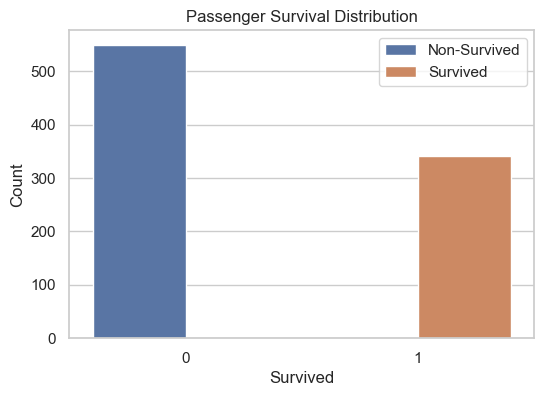

In [39]:
# Assuming 'train_df' is the DataFrame containing the data
sns.set(style="whitegrid")  

plt.figure(figsize=(6, 4)) 
sns.countplot(x='survived', data=train_df, hue="survived")  
plt.xlabel('Survived')  
plt.ylabel('Count')  
plt.title('Passenger Survival Distribution')  
plt.legend(labels=['Non-Survived', 'Survived'])

plt.show()


In [40]:
print("Categorical feature distributions:")
print(train_df['sex'].value_counts())
print(train_df['pclass'].value_counts())
print(train_df['embarked'].value_counts())

Categorical feature distributions:
male      577
female    314
Name: sex, dtype: int64
3    491
1    216
2    184
Name: pclass, dtype: int64
s    644
c    168
q     77
Name: embarked, dtype: int64


In [54]:
print("Outliers in 'Age':")
train_df[train_df['age'] > train_df['age'].mean() + 3 * train_df['age'].std()]

Outliers in 'Age':


,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked_port
630,1,1,"barkworth, mr. algernon henry wilson",male,80.0,0,0,27042,30.000,a23,southampton
851,0,3,"svensson, mr. johan",male,74.0,0,0,347060,7.775,NaN,southampton


In [55]:
print("Outliers in 'Fare':")
fare_outliers = train_df[train_df['fare'] > train_df['fare'].mean() + 3 * train_df['fare'].std()]
fare_outliers[fare_outliers.fare>300]

Outliers in 'Fare':


,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked_port
258,1,1,"ward, miss. anna",female,35.0,0,0,pc 17755,512.3292,NaN,cherbourg
679,1,1,"cardeza, mr. thomas drake martinez",male,36.0,0,1,pc 17755,512.3292,b51 b53 b55,cherbourg
737,1,1,"lesurer, mr. gustave j",male,35.0,0,0,pc 17755,512.3292,b101,cherbourg


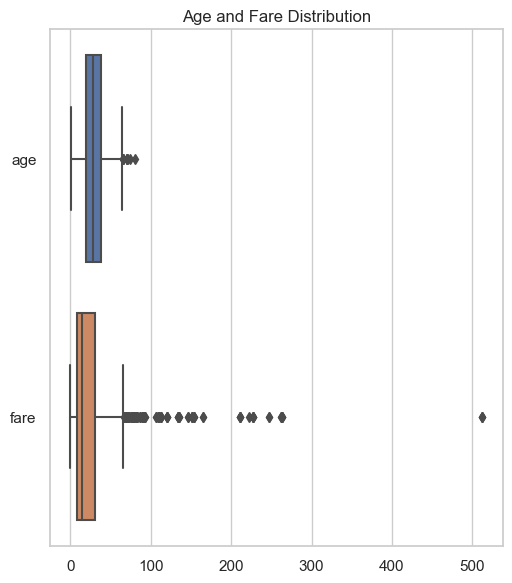

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_side_by_side_violin(data, title):
    sns.set(style="whitegrid")  
    plt.figure(figsize=(10, 6))  
    plt.subplot(1, 2, 1)  
    sns.boxplot(data=data[["age", "fare"]], orient="h")
    plt.title(f'{title}')

    plt.tight_layout()  
    plt.show()

plot_side_by_side_violin(train_df, 'Age and Fare Distribution')


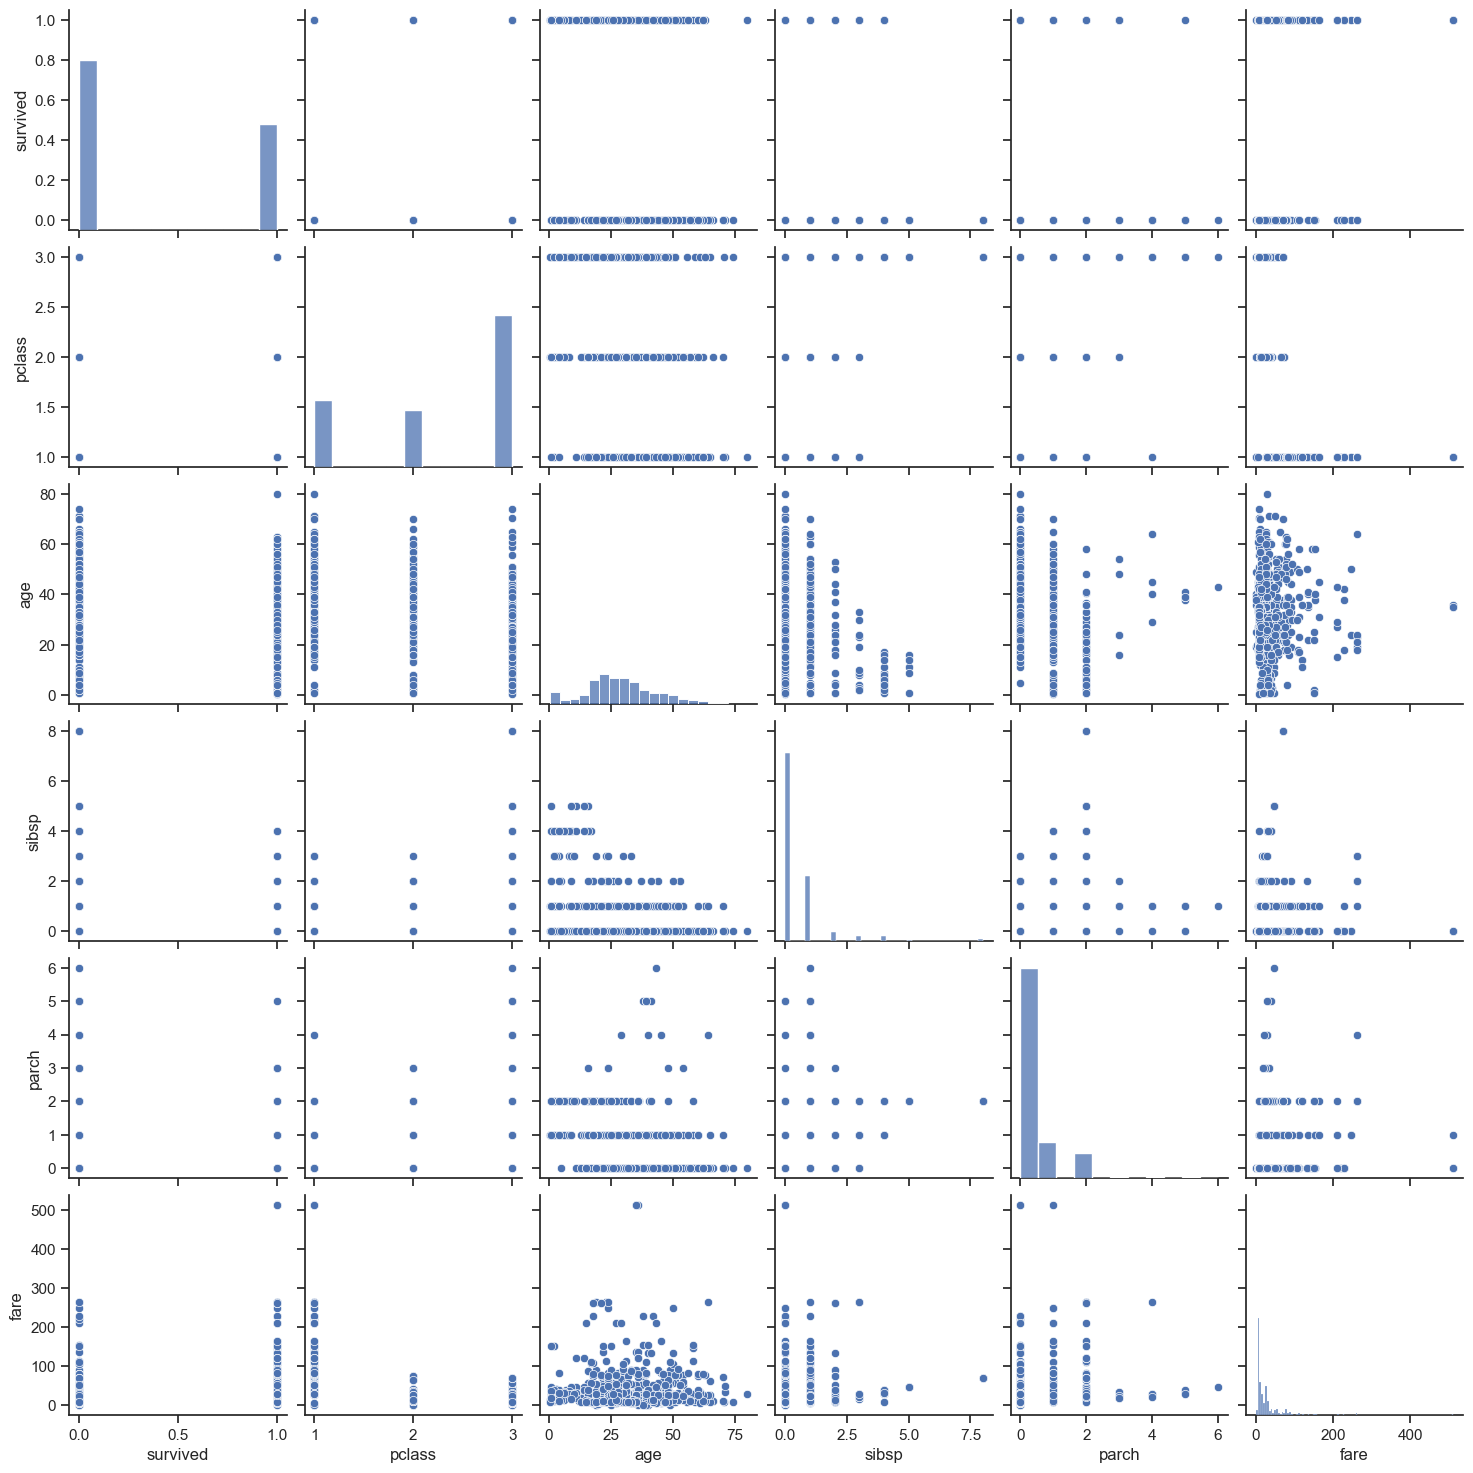

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_df' is the DataFrame containing the data
sns.set(style="ticks")  # Set the seaborn style

# Create a scatter plot for multiple variables
sns.pairplot(train_df)
plt.show()


<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #b47238; text-align: left; "><b>Initial Conclusions from Exploratory Data Analysis (EDA):</b></h1>

1. The train dataset contains 891 records and 12 columns, meaning it contains information about 891 passengers and various aspects related to them.

2. The 'cabin' column has a significant number of missing values, approximately 77% of the data is missing. This could be a challenge for our analysis and modeling since we have limited information about the cabins.

3. The 'age' column also has missing values, but the percentage is relatively lower, around 19.8%. We will need to handle these missing values thoughtfully to avoid bias in our analysis.

4. The 'embarked' column has only 2 missing values, which is a small proportion of the dataset. We can consider various strategies to deal with these missing values, such as imputation or excluding those rows.

5. The target variable is called 'survived', and it indicates whether a passenger survived (1) or not (0). The data is imbalanced with 62% of non-survivors and 38% of survivors. This imbalance might impact our model's performance, and we might need to use techniques like resampling or different evaluation metrics to handle it.

6. The mean survival rate is approximately 38.38%, indicating that about 38.38% of the passengers in the dataset survived the Titanic disaster.

7. The passengers' ages range from approximately 5 months (0.42 years) to 80 years old, with an average age of around 29.70 years.

8. On average, passengers tend to travel with few family members. The 'sibsp' column, representing the number of siblings and spouses aboard, has a mean value of 0.52, and the 'parch' column, representing the number of parents and children aboard, has a mean value of 0.38.

9. The average fare paid by passengers is approximately 32.20 units. However, some passengers received complimentary tickets or traveled for free, as indicated by the minimum fare of 0 units. On the other hand, some passengers paid significantly higher fares, with the maximum fare being 512.33 units.

***Additional Insights:***

10. Three passengers paid the highest fare of 512.33 units and survived the disaster. They were embarked at the port Cherbourg and belonged to the first class. Their ages were between 35 and 36 years old, and interestingly, most of them were traveling alone, except one passenger who had either a parent or child aboard.

In [24]:
age_by_class = train_df.groupby('pclass').age.count()
age_by_class

pclass
1    186
2    173
3    355
Name: age, dtype: int64

<AxesSubplot:xlabel='age', ylabel='class'>

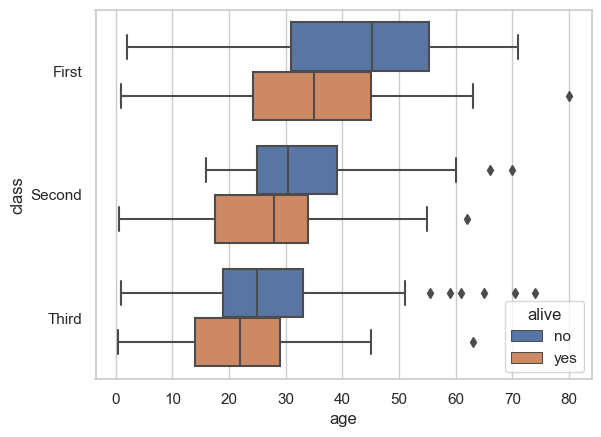

In [28]:
df = sns.load_dataset("titanic")
sns.boxplot(data=df, x="age", y="class", hue="alive")

In [30]:
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True
